In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import IPython
import IPython.display

import tensorflow as tf
from keras.layers import Dense, LSTM


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# sklearn config
from sklearn import set_config
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# IMPORT DATA

In [3]:
header_local = ['date', 'KLGD', 'GTGD', 'capital', 'close_price', 'daily_return','daily_return_pct', 'KL', 'GT']
column_range = list(range(9))
df_local = pd.read_csv("data\MWG-12423.csv", skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for local invest
df_local.columns = header_local
print(f"Dữ liệu bao gồm {df_local.shape[0]} dòng và {df_local.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_local.head()

Dữ liệu bao gồm 251 dòng và 9 cột:
Mẫu bảng dữ liệu :



,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,11/04/2023,"5,749,500","242,682","59,559","40,700",-300,-0.73,"2,852,300","115,640"
1,10/04/2023,"10,616,296","436,606","59,998","41,000","2,000",5.13,"5,829,400","236,992"
2,07/04/2023,"2,661,000","105,114","57,072","39,000",-100,-0.26,"2,032,200","78,830"
3,06/04/2023,"2,531,100","101,826","57,218","39,100",-650,-1.64,"1,971,300","78,034"
4,05/04/2023,"1,735,900","68,838","58,169","39,750",-50,-0.13,"1,735,900","68,838"


In [4]:
header_foreign = ['date', 'room', 'remain_room_stk','remain_room_pct','kl_buy','kl_buy_pct', 'gt_buy','gt_buy_pct','kl_sell','kl_sell_pct', 'gt_sell','gt_sell_pct','KL_foreign_diff','GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct']
column_range = list(range(18))
df_foreign = pd.read_csv("data\MWG-ndtnn-12423.csv", skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for foreign invest
df_foreign.columns = header_foreign
print(f"Dữ liệu bao gồm {df_foreign.shape[0]} dòng và {df_foreign.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_foreign.head()

Dữ liệu bao gồm 251 dòng và 18 cột:
Mẫu bảng dữ liệu :



,date,room,remain_room_stk,remain_room_pct,kl_buy,kl_buy_pct,gt_buy,gt_buy_pct,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,11/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"2,897,200",100,"127,042,220,000",100
1,10/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"5,403,900",112.89,"225,342,630,000",112.89
2,07/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"628,800",100,"26,283,840,000",100
3,06/04/2023,"717,300,847",-,NaN,100,0.01,"4,000,000",0.01,-,NaN,-,NaN,100,"4,000,000","559,800",100,"23,791,500,000",100
4,05/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,-,NaN,-,NaN


In [5]:
foreign_main_cols = header_foreign[3:]
print(foreign_main_cols)

['remain_room_pct', 'kl_buy', 'kl_buy_pct', 'gt_buy', 'gt_buy_pct', 'kl_sell', 'kl_sell_pct', 'gt_sell', 'gt_sell_pct', 'KL_foreign_diff', 'GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct']


# PREPROCESSING

In [6]:
# Convert the date column to a pandas datetime object
df_local['date'] = pd.to_datetime(df_local['date'], dayfirst=True)
df_local = df_local.sort_values(by='date', ascending=True, ignore_index = True)
df_local.head()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,2022-04-12,"4,276,300","656,745","111,780","152,700","2,700",1.80,"2,644,500","394,841"
1,2022-04-13,"12,958,400","2,045,754","114,342","156,200","3,500",2.29,"3,406,000","520,444"
2,2022-04-14,"2,992,800","477,771","116,758","159,500","3,300",2.11,"2,925,900","467,335"
3,2022-04-15,"2,959,800","480,101","117,270","160,200",700,0.44,"2,339,800","374,329"
4,2022-04-18,"2,933,800","474,702","117,270","160,200",NaN,NaN,"2,616,900","420,385"


In [7]:
# Convert the date column to a pandas datetime object
df_foreign['date'] = pd.to_datetime(df_foreign['date'], dayfirst=True)
df_foreign = df_foreign.sort_values(by='date', ascending=True, ignore_index = True)
df_foreign.head()

,date,room,remain_room_stk,remain_room_pct,kl_buy,kl_buy_pct,gt_buy,gt_buy_pct,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,2022-04-12,"349,402,092",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"1,631,800",100,"261,903,900,000",100
1,2022-04-13,"358,805,667",10,NaN,"15,100",0.44,"2,280,100,000",0.44,-,NaN,-,NaN,"15,100","2,280,100,000","9,552,400",100,"1,525,309,700,000",100
2,2022-04-14,"358,805,667",10,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,-,NaN,-,NaN
3,2022-04-15,"358,805,667",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"620,000",100,"105,772,000,000",100
4,2022-04-18,"358,805,667",-,NaN,-,NaN,-,NaN,"3,800",0.15,"612,110,000",0.15,"-3,800","-612,110,000","316,900",100,"54,316,660,000",100


Convert type

In [8]:
def convert_type(dataframe):
    dataframe = dataframe.fillna(0)
    for col in dataframe.columns:
        if col == 'date':
            continue
        else:
            dataframe[col] = dataframe[col].apply(
                lambda x: float(str(x).replace(',', '').replace('-', '0'))
                if isinstance(x, str) and x.strip() != ''
                else (np.nan if isinstance(x, str) and x.strip() == '' else x)
            )
    return dataframe
df_local = convert_type(df_local)
df_foreign = convert_type(df_foreign)

Merge 2 dataframes

In [9]:
df = pd.merge(df_local, df_foreign, on="date")
df.tail()
    

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,room,...,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
246,2023-04-05,1735900.0,68838.0,58169.0,39750.0,50.0,-0.13,1735900.0,68838.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.00
247,2023-04-06,2531100.0,101826.0,57218.0,39100.0,650.0,-1.64,1971300.0,78034.0,717300847.0,...,0.0,0.0,0.0,0.0,100.0,4000000.0,559800.0,100.00,2.379150e+10,100.00
248,2023-04-07,2661000.0,105114.0,57072.0,39000.0,100.0,-0.26,2032200.0,78830.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,628800.0,100.00,2.628384e+10,100.00
249,2023-04-10,10616296.0,436606.0,59998.0,41000.0,2000.0,5.13,5829400.0,236992.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5403900.0,112.89,2.253426e+11,112.89
250,2023-04-11,5749500.0,242682.0,59559.0,40700.0,300.0,-0.73,2852300.0,115640.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2897200.0,100.00,1.270422e+11,100.00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 250
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              251 non-null    datetime64[ns]
 1   KLGD              251 non-null    float64       
 2   GTGD              251 non-null    float64       
 3   capital           251 non-null    float64       
 4   close_price       251 non-null    float64       
 5   daily_return      251 non-null    float64       
 6   daily_return_pct  251 non-null    float64       
 7   KL                251 non-null    float64       
 8   GT                251 non-null    float64       
 9   room              251 non-null    float64       
 10  remain_room_stk   251 non-null    float64       
 11  remain_room_pct   251 non-null    float64       
 12  kl_buy            251 non-null    float64       
 13  kl_buy_pct        251 non-null    float64       
 14  gt_buy            251 non-

In [11]:
df.describe()

,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,room,remain_room_stk,...,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
count,2.510000e+02,2.510000e+02,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000,2.510000e+02,2.510000e+02,...,2.510000e+02,251.000000,2.510000e+02,251.000000,2.510000e+02,2.510000e+02,2.510000e+02,251.000000,2.510000e+02,251.000000
mean,3.636948e+06,2.406912e+05,81808.063745,69675.099602,1437.450199,-0.200398,2.816721e+06,186330.035857,6.330065e+08,1.330300e+05,...,1.390789e+05,3.909084,9.572308e+09,3.909084,8.491843e+04,5.889690e+09,7.929065e+05,78.059084,4.629064e+10,69.753307
std,2.313943e+06,1.871855e+05,19834.510435,37382.305808,1769.799953,2.854440,1.570506e+06,121150.446446,1.523935e+08,5.865985e+05,...,5.484412e+05,12.224354,3.226533e+10,12.224354,2.790843e+05,1.977281e+10,1.426432e+06,81.123328,1.120883e+11,83.459346
min,5.777000e+05,4.609500e+04,51083.000000,37700.000000,0.000000,-7.000000,5.421000e+05,34268.000000,3.494021e+08,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2.233250e+06,1.231535e+05,62746.000000,43000.000000,325.000000,-1.530000,1.671700e+06,91213.500000,7.173008e+08,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,2.992800e+06,1.872390e+05,84163.000000,59000.000000,850.000000,0.000000,2.540800e+06,159924.000000,7.173008e+08,0.000000e+00,...,1.100000e+01,0.000000,0.000000e+00,0.000000,6.850000e+02,8.420000e+06,3.200000e+05,100.000000,1.617396e+10,100.000000
75%,4.325189e+06,3.148875e+05,99690.000000,72000.000000,1900.000000,1.290000,3.678750e+06,251655.000000,7.173008e+08,0.000000e+00,...,6.650000e+03,0.215000,4.178900e+08,0.215000,9.600000e+03,5.634300e+08,9.002500e+05,100.000000,5.816502e+10,100.000000
max,1.368460e+07,2.045754e+06,117270.000000,160200.000000,10900.000000,6.990000,1.084750e+07,778223.000000,7.174145e+08,3.608693e+06,...,6.754080e+06,108.590000,3.256277e+11,108.590000,2.554100e+06,1.919450e+11,9.552400e+06,1096.020000,1.525310e+12,1096.020000


Plotting the data

In [12]:
df['date'] = pd.to_datetime(df['date'])
# Set the 'Date' column as the index
df.set_index('date', inplace=True)

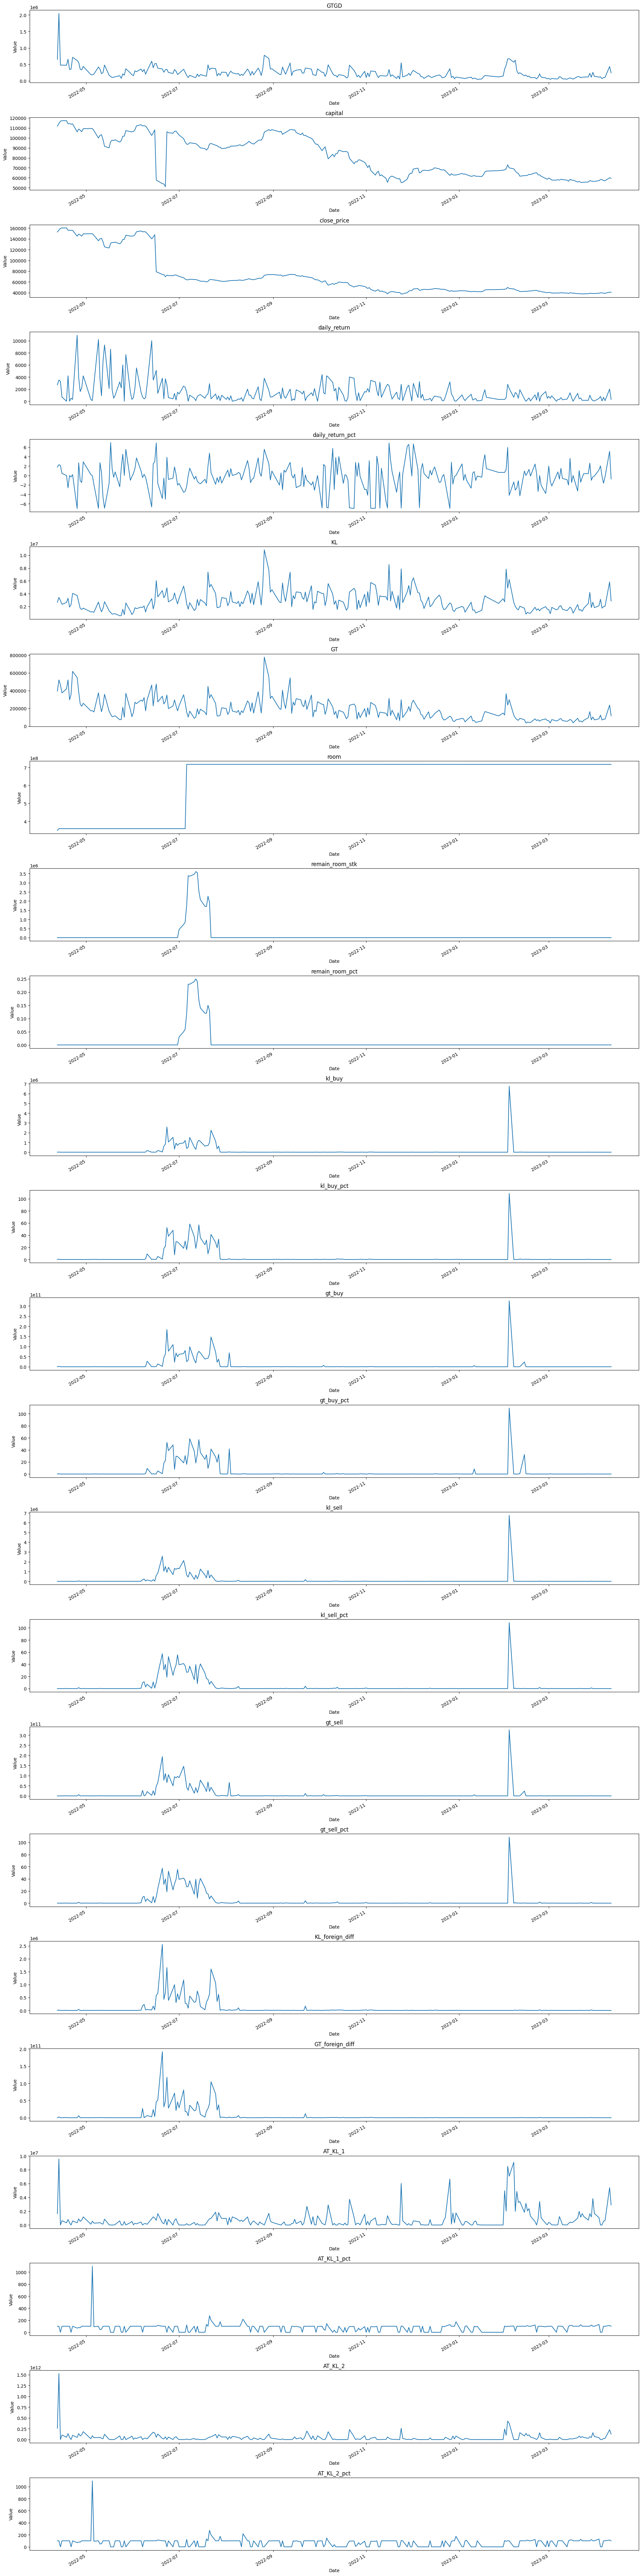

In [13]:
# Create subplots
fig, axes = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(20, 80))

# Plot each column on a separate subplot
for i, col in enumerate(df.columns[1:]):
    df[col].plot(ax=axes[i], title=col)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

Correlation

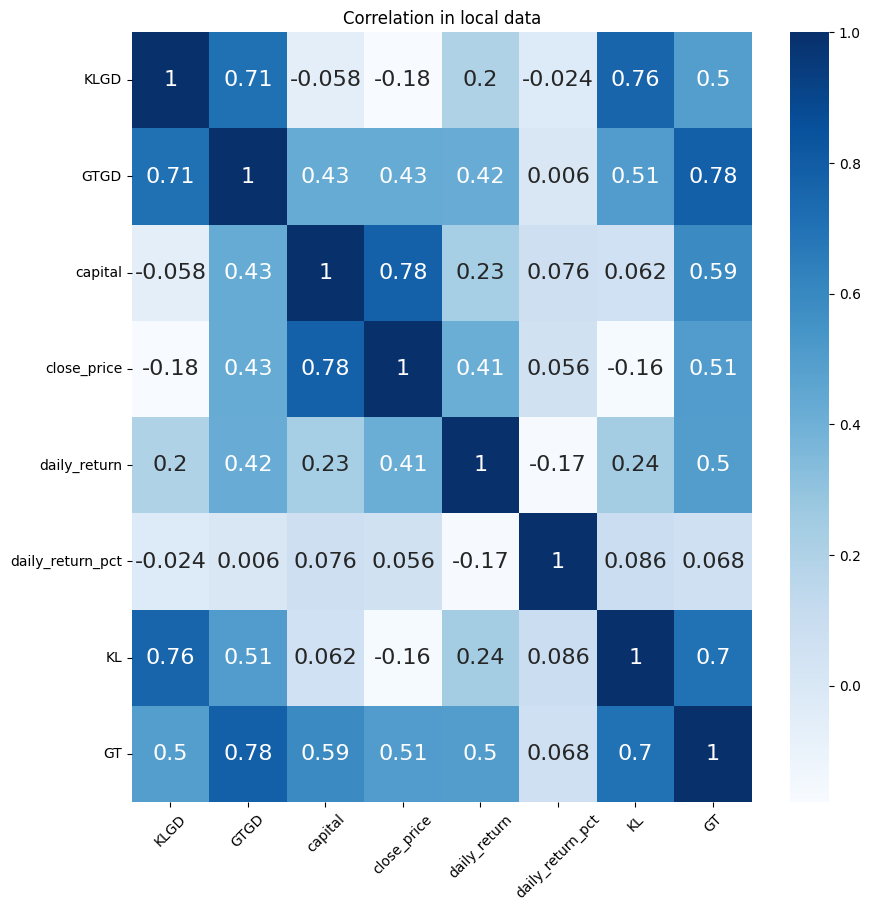

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df_local.corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)
ax.set_title('Correlation in local data')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

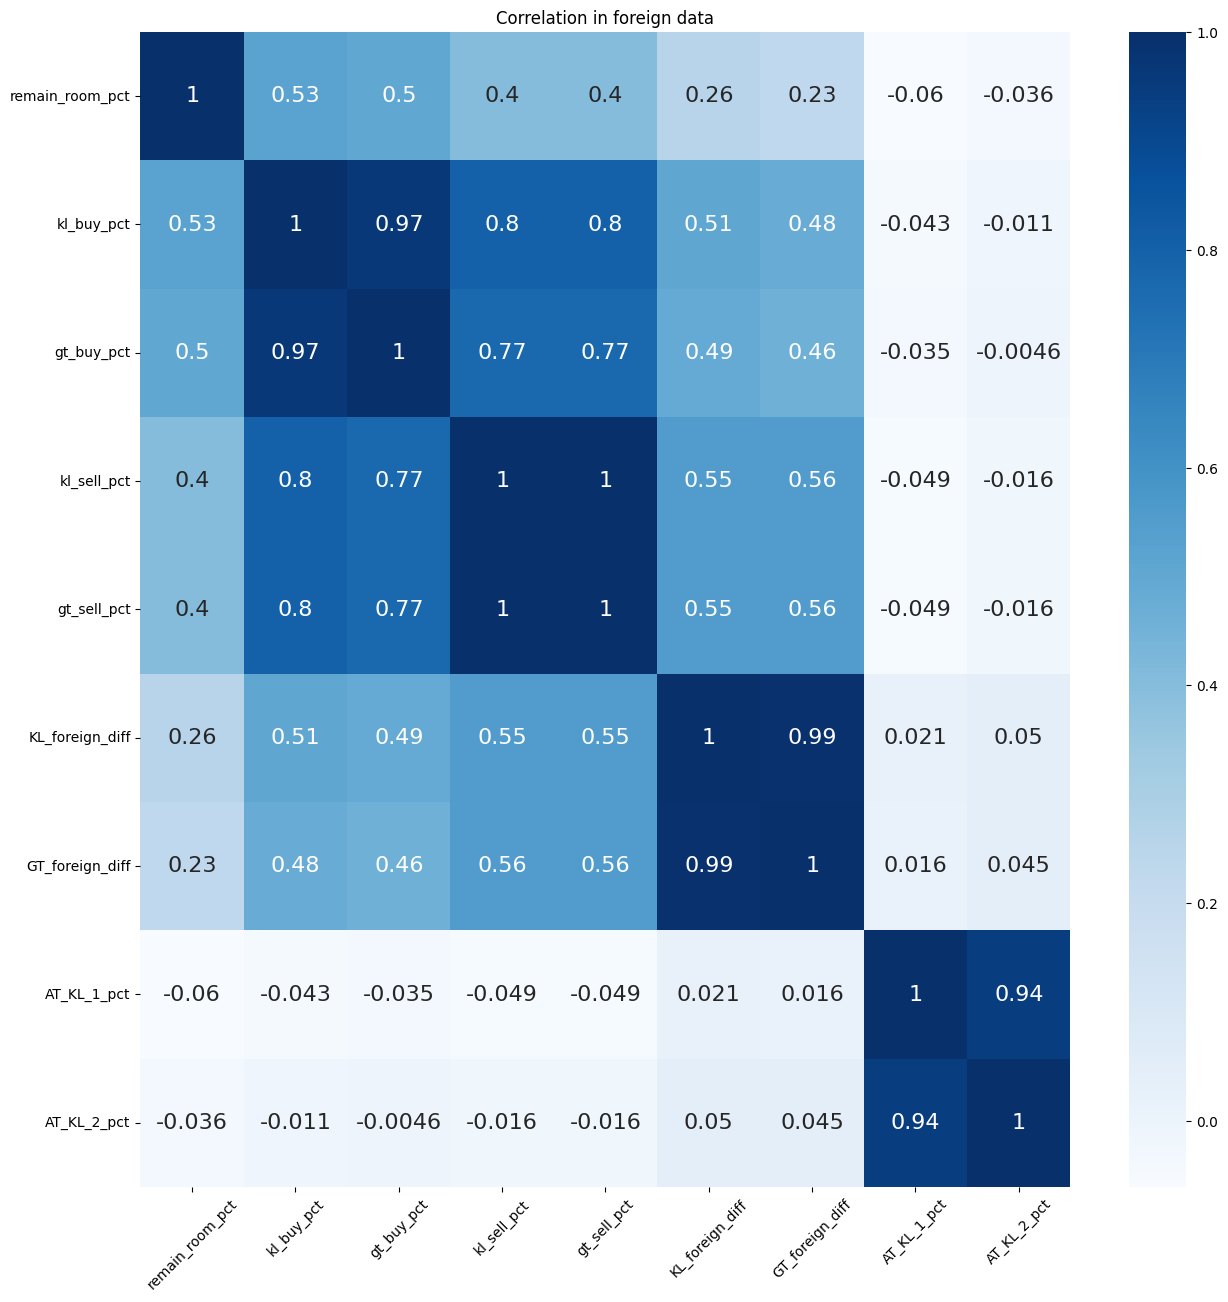

In [15]:
foreign_pct_cols = ['remain_room_pct','kl_buy_pct', 'gt_buy_pct', 'kl_sell_pct', 'gt_sell_pct', 'KL_foreign_diff', 'GT_foreign_diff', 'AT_KL_1_pct', 'AT_KL_2_pct']

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_foreign[foreign_pct_cols].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)
ax.set_title('Correlation in foreign data')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

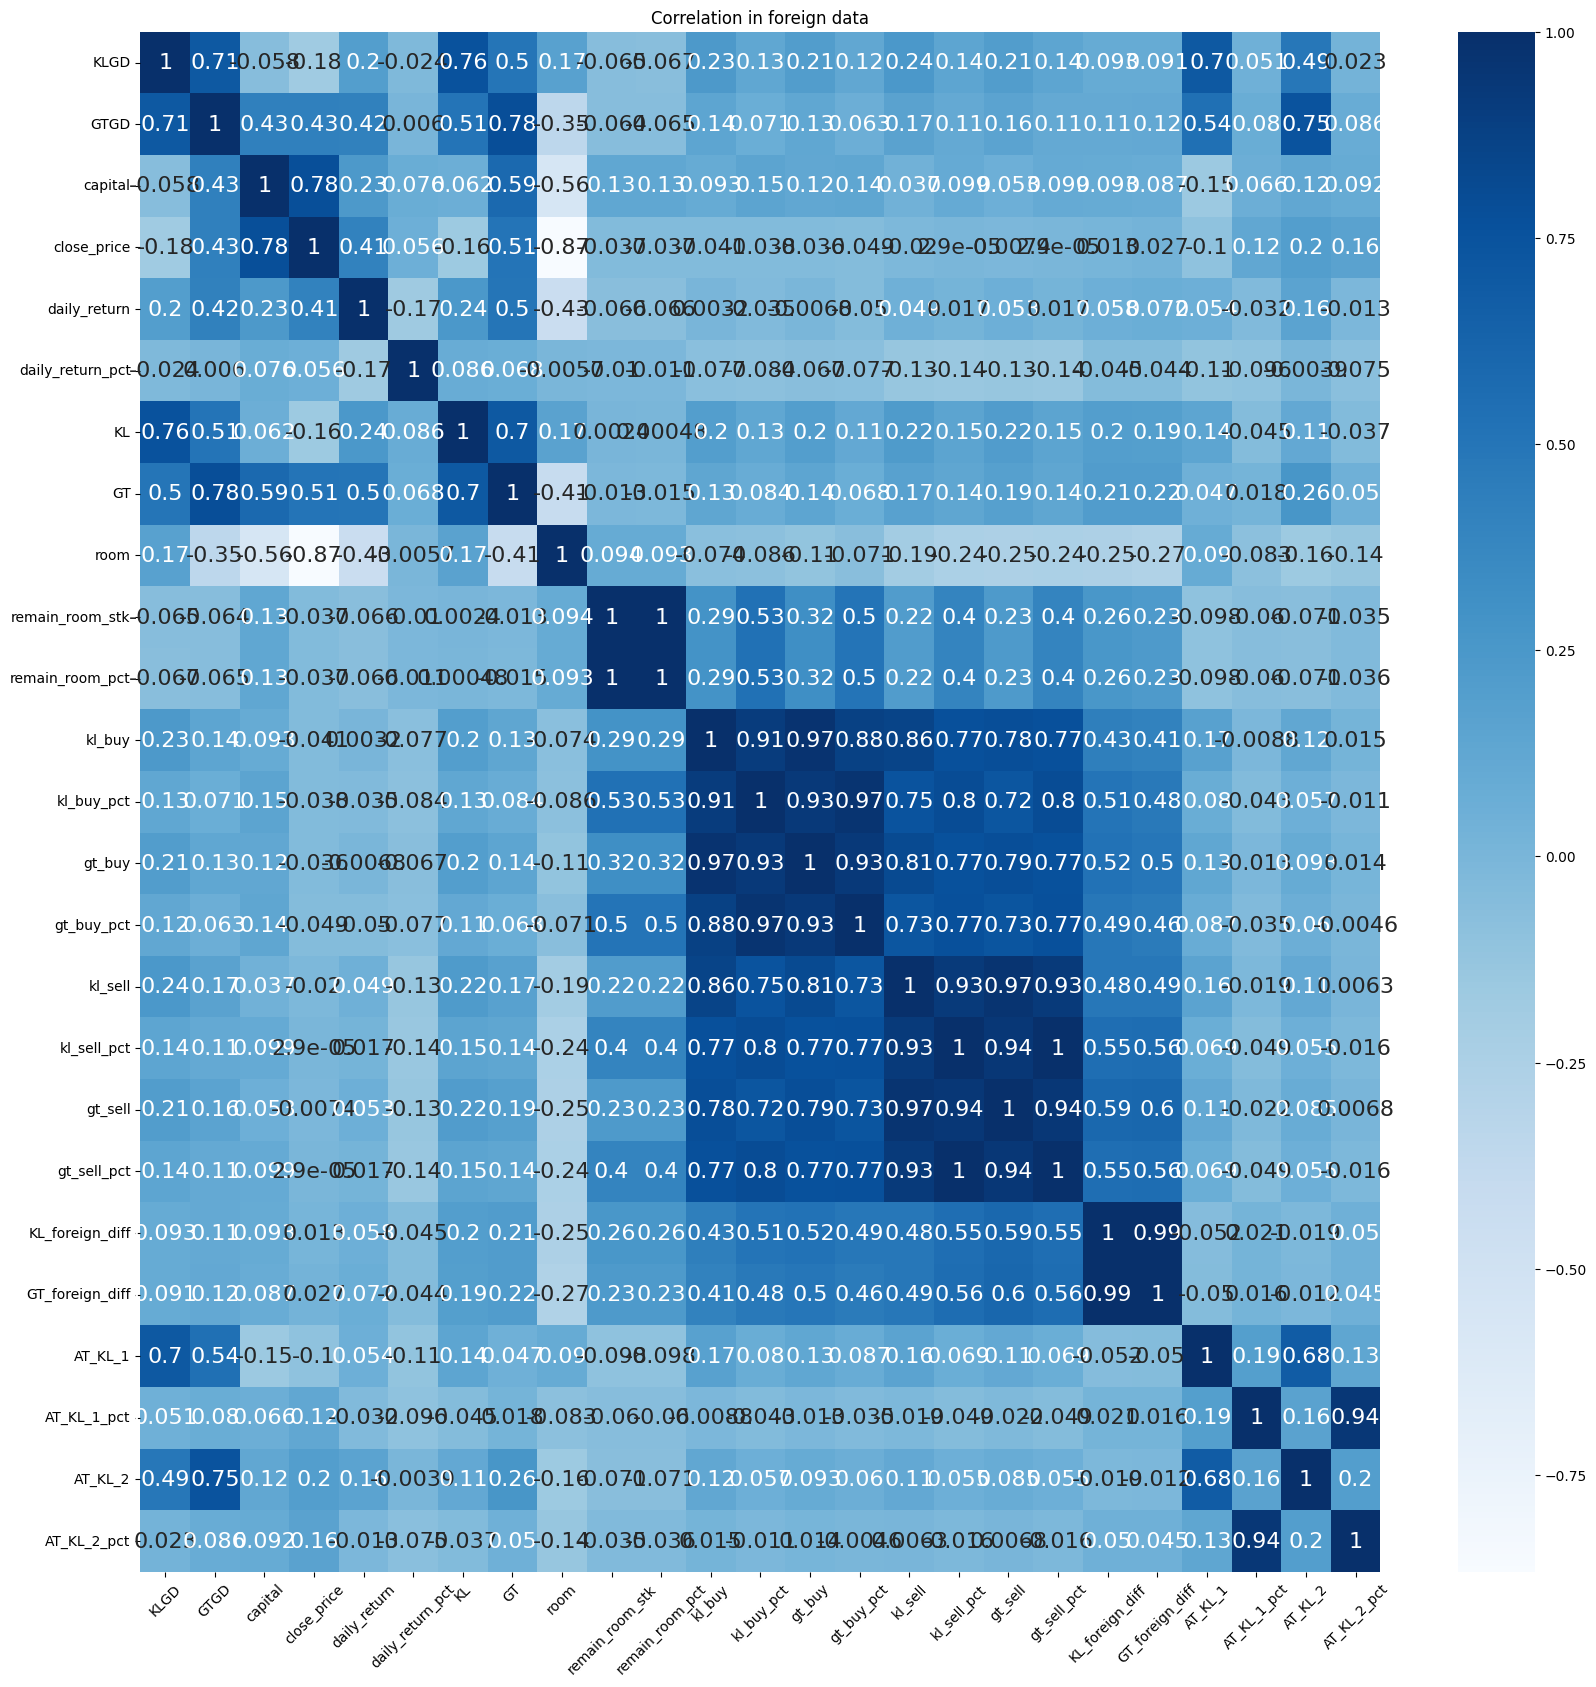

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(df.corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)
ax.set_title('Correlation in foreign data')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);